In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns; sns.set_theme()
import os

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array

## Preprocessing Data

In [ ]:
IMAGE_SIZE = (224, 224)

def resize_with_padding(img, target_size=(224, 224)):
    img = img.astype(np.uint8)
    h, w = img.shape[:2]
    scale = min(target_size[0]/h, target_size[1]/w)
    new_h, new_w = int(h * scale), int(w * scale)

    img_resized = Image.fromarray(img).resize((new_w, new_h), Image.BILINEAR)

    # Padding hitam
    padded = Image.new("RGB", target_size, color=(0, 0, 0))
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    padded.paste(img_resized, (left, top))
    return np.array(padded)

def preprocess_input_with_padding(img):
    img = np.array(img)
    padded = resize_with_padding(img, target_size=IMAGE_SIZE)
    padded = img_to_array(padded)
    return preprocess_input(padded)

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input_with_padding)

## Data Preparation

In [ ]:
# # Jalur ke direktori data
base_dir = 'Datasets_Compvis/Dataset'

training_data = os.path.join(base_dir, 'Train')
validation_data = os.path.join(base_dir, 'Validation')
test_data = os.path.join(base_dir, 'Test')

In [ ]:
# # Jalur ke direktori data
# training_data = '/content/drive/MyDrive/Colab Notebooks/Dataset/Train'
# validation_data = '/content/drive/MyDrive/Colab Notebooks/Dataset/Validation'
# test_data = '/content/drive/MyDrive/Colab Notebooks/Dataset/Test'

# Memuat data gambar dari direktori dengan mempertahankan rasio aspek
training_image_data = image_generator.flow_from_directory(
    training_data,
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

validation_image_data = image_generator.flow_from_directory(
    validation_data,
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

test_image_data = image_generator.flow_from_directory(
    test_data,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False,
    batch_size=44
)

Found 212 images belonging to 5 classes.
Found 44 images belonging to 5 classes.
Found 44 images belonging to 5 classes.


## Mempersiapkan Label Kelas

In [ ]:
class_names = np.array(list(training_image_data.class_indices.keys()))
class_names

array(['0', '1', '2', '3', '4'], dtype='<U1')

## Load Pre-trained Model MobileNetV2

In [ ]:
IMG_SHAPE = IMAGE_SIZE + (3,)
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

MobileNetV2.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Build Model Akhir

In [ ]:
from tensorflow.keras import regularizers

# mendefinisikan model_poster
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)  # Scale [-1, 1]
x = MobileNetV2(x, training=False)  # Inference mode for frozen model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_poster = tf.keras.Model(inputs, outputs)

In [ ]:
from tensorflow.keras.utils import plot_model

# Menampilkan arsitektur model di console
model_poster.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,174,225 (19.74 MB)

 Trainable params: 1,373,253 (5.24 MB)

 Non-trainable params: 1,054,464 (4.02 MB)

 Optimizer params: 2,746,508 (10.48 MB)

## Compile Model

In [ ]:
model_poster.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

## Buat Callback untuk Mengumpulkan Statistik Training

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    # self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

## Train Model

In [ ]:
history = model_poster.fit(training_image_data, epochs = 8,
                          validation_data=validation_image_data, callbacks=[batch_stats_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - accuracy: 0.2223 - loss: 2.6864 - val_accuracy: 0.2273 - val_loss: 2.2713
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 362ms/step - accuracy: 0.5155 - loss: 1.5788 - val_accuracy: 0.2955 - val_loss: 1.9766
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.6164 - loss: 1.3823 - val_accuracy: 0.2727 - val_loss: 1.9585
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step - accuracy: 0.7042 - loss: 1.1299 - val_accuracy: 0.3182 - val_loss: 2.0454
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.7741 - loss: 0.7864 - val_accuracy: 0.2955 - val_loss: 2.0608
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.8531 - loss: 0.6616 - val_accuracy: 0.3409 - val_loss: 2.0714
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.8526 - loss: 0.5960 - val_accuracy: 0.3636 - val_loss: 2.0689
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.8641 - loss: 0.6186 - val_accuracy: 0.3636 - val_loss: 2.0680

## Visualisasi Training

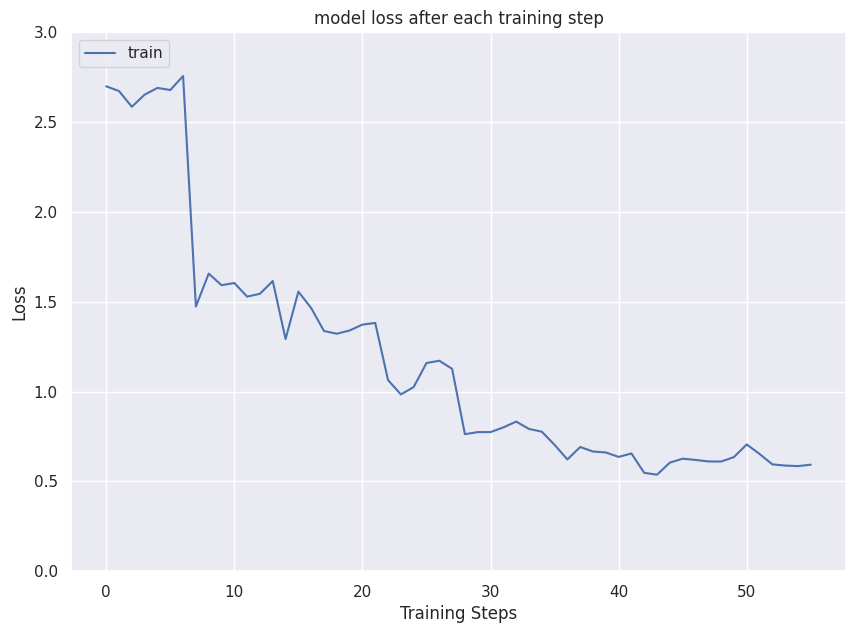

In [ ]:
plt.figure(figsize=(10,7))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,3])
plt.plot(batch_stats_callback.batch_losses)
plt.title('model loss after each training step')
plt.legend(['train'], loc='upper left')

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


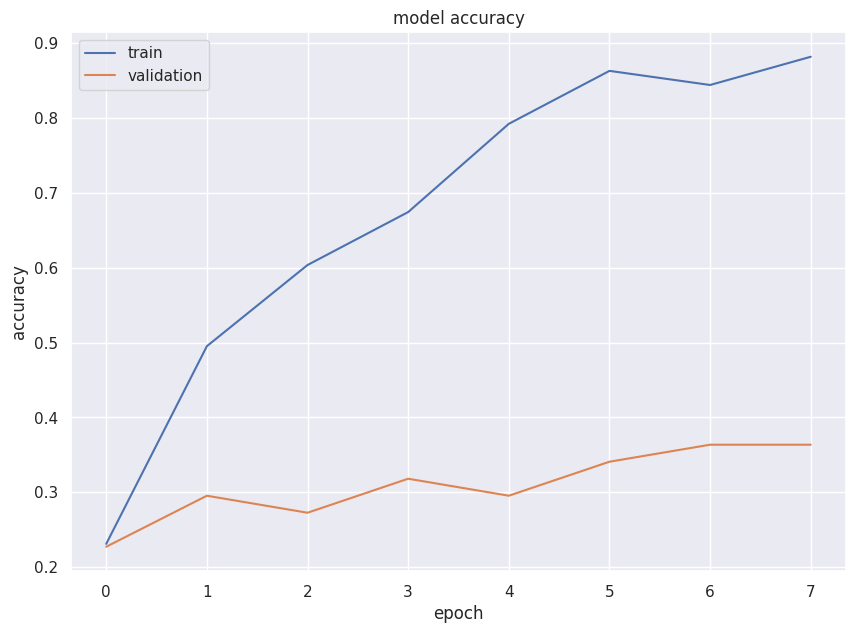

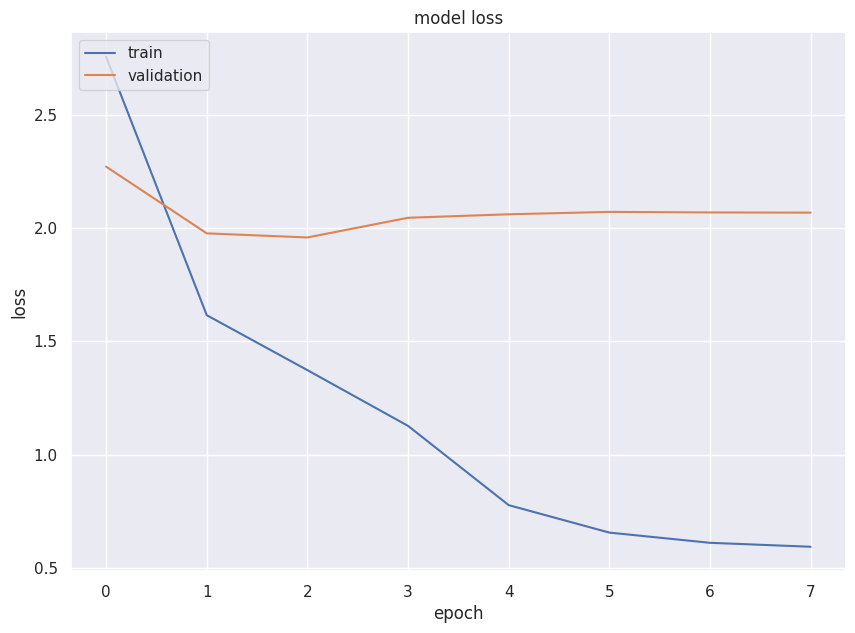

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Prediksi dan Visualisasi Hasil Prediksi pada Training Batch

In [ ]:
for image_batch, label_batch in training_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
arr = model_poster.predict(image_batch)
predicted_id = np.argmax(arr, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)
true_label_batch = class_names[label_id]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


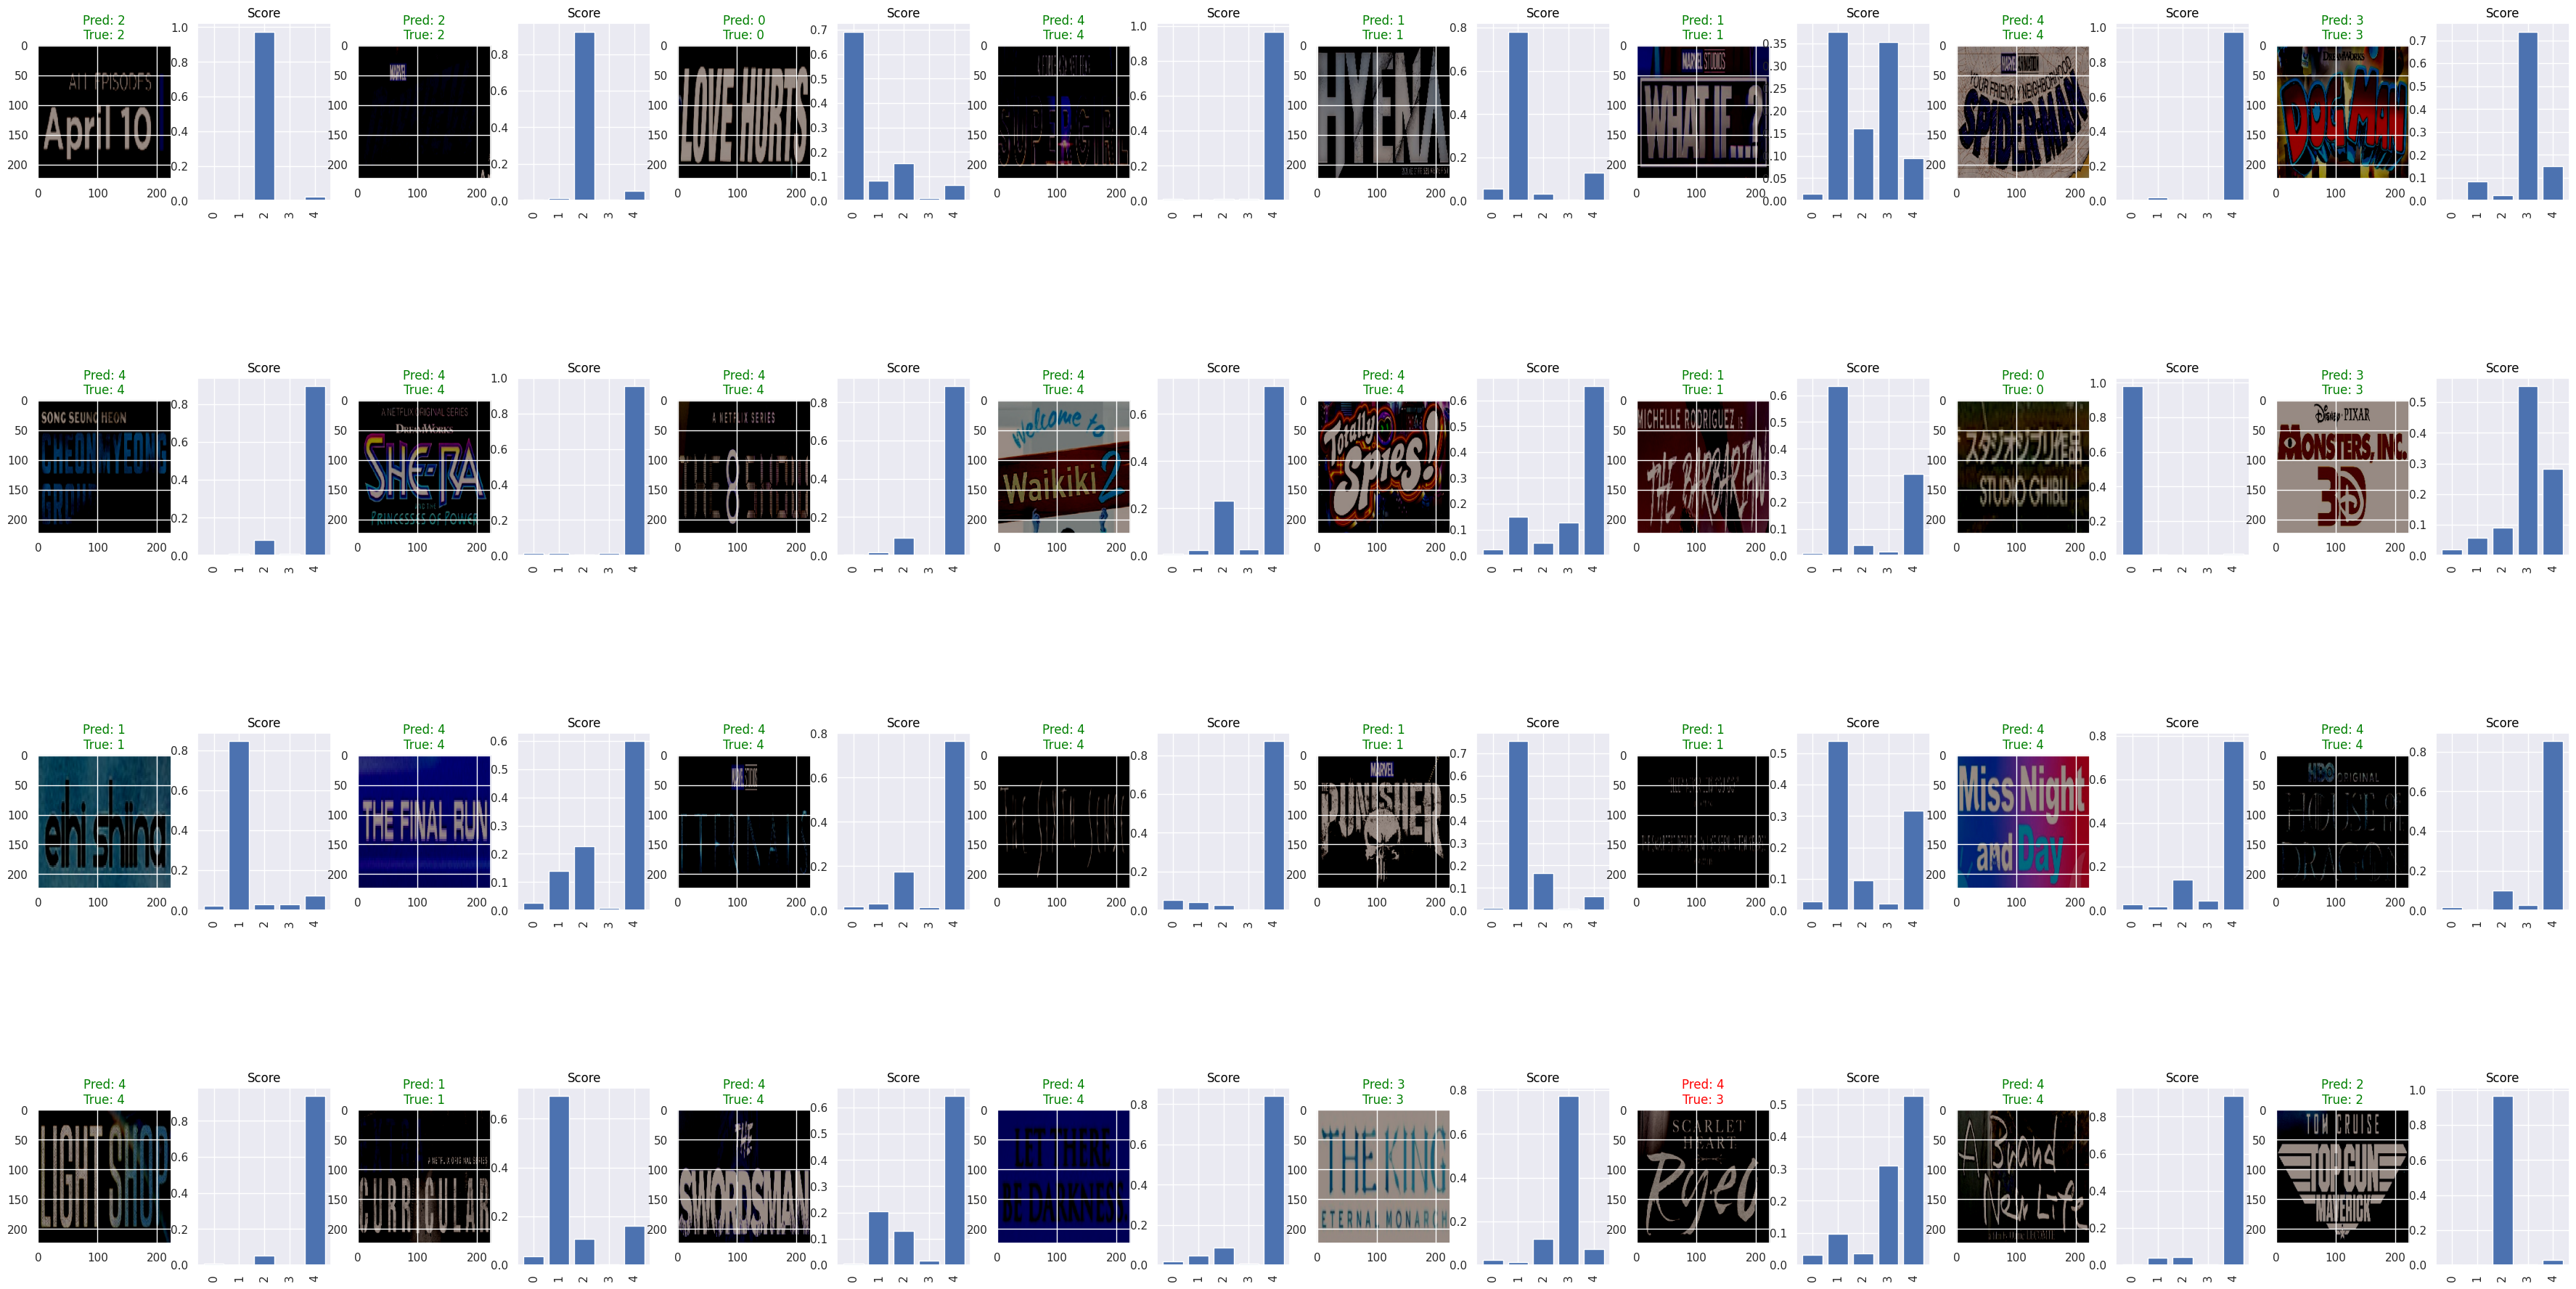

In [ ]:
img_counter=0
prob_counter=0

image_batch = np.clip(image_batch, 0, 255)  # Clip to [0, 255]
image_batch = image_batch.astype(np.uint8)  # Convert to uint8

plt.figure(figsize=(45,200))
plt.subplots_adjust(hspace=1)
for n in range(64):

  plt.subplot(32,16,n+1)
  if(n%2==0):
      plt.imshow(image_batch[img_counter])
      color = "green" if predicted_id[img_counter] == label_id[img_counter] else "red"
      plt.title("Pred: "+predicted_label_batch[img_counter].title()+"\nTrue: "+true_label_batch[img_counter], color=color)
      img_counter=img_counter+1

  if(n%2==1):
      plt.title("Score", color="Black")

      data=[arr[prob_counter][0],arr[prob_counter][1],arr[prob_counter][2],
            arr[prob_counter][3], arr[prob_counter][4]
            ]

      plt.bar(class_names,data)
      plt.xticks(rotation='vertical')

      prob_counter=prob_counter+1

## Evaluasi Model di Data Test

In [ ]:
for image_batch, label_batch in test_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (44, 224, 224, 3)
Label batch shape:  (44, 5)


In [ ]:
predicted_batch = model_poster.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
# # Evaluasi model di data test
# test_loss, test_acc = model_poster.evaluate(test_image_data)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")

## Confusion Matrix

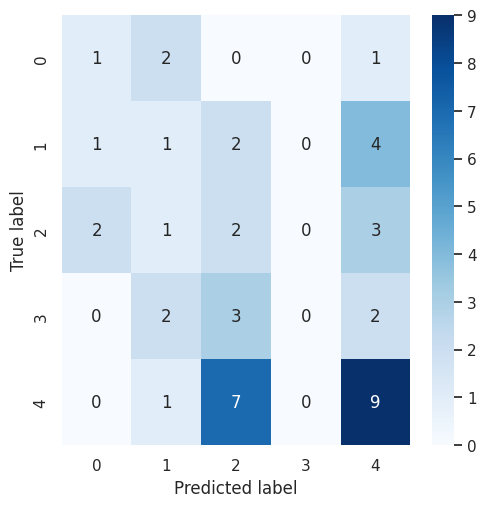

In [ ]:
con_mat_df=tf.math.confusion_matrix(
    labels = label_id , predictions = predicted_id
)

figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Classification Report

In [ ]:
print(classification_report(label_id, predicted_id, zero_division=0))

              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
           1       0.14      0.12      0.13         8
           2       0.14      0.25      0.18         8
           3       0.00      0.00      0.00         7
           4       0.47      0.53      0.50        17

    accuracy                           0.30        44
   macro avg       0.20      0.23      0.21        44
weighted avg       0.26      0.30      0.27        44

